In [ ]:
import openml

In [ ]:
benchmark_suite = openml.study.get_suite('OpenML-CC18') # obtain the benchmark suite

benchmark_suite

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

df = pd.read_csv('php0iVrYT.csv');

data = df.values[:, :4].astype(int);
target = df.values[:, 4].astype(int);
d_name = np.array(df.columns[:4]);
t_name = np.array(df.columns[4]);

# Visualization

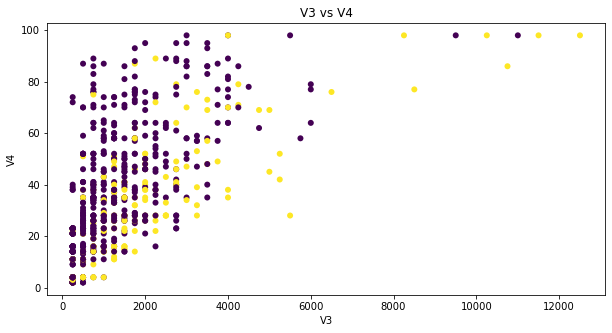

In [3]:
#plot two features
i, j = 2, 3;

plt.figure(figsize=(10,5));
plt.scatter(data[:,i], data[:,j], edgecolor='none', c=target);

xlabel(d_name[i]);
ylabel(d_name[j]);
title(d_name[i] + ' vs ' + d_name[j]);

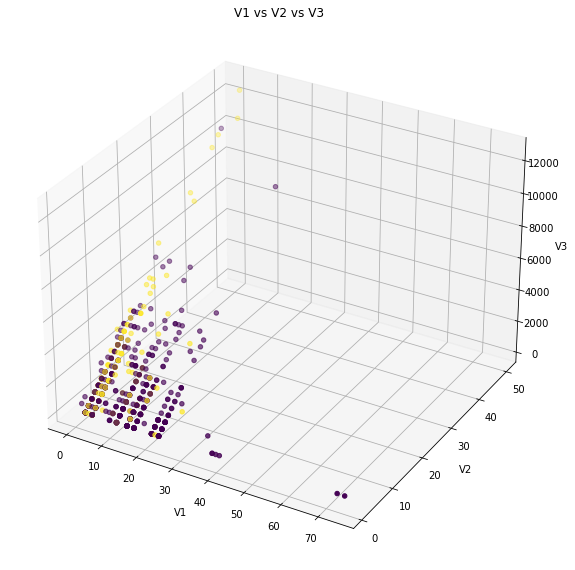

In [4]:
#plot three features
from mpl_toolkits.mplot3d import Axes3D
i,j,k = 0, 1, 2;

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111, projection = '3d');
ax.scatter(data[:,i], data[:,j], data[:,k], c=target);
ax.set_xlabel(d_name[i]);
ax.set_ylabel(d_name[j]);
ax.set_zlabel(d_name[k]);
ax.set_title(d_name[i] + ' vs ' + d_name[j] + ' vs ' + d_name[k], y=1.08);

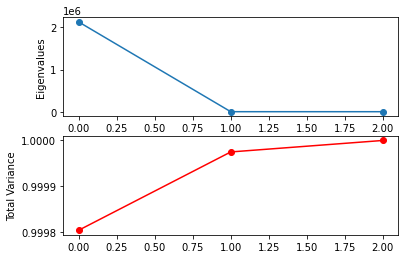

In [5]:
#explained variance
from sklearn.decomposition import PCA

X = data.copy();
pca = PCA(n_components = 3, whiten = False);
X = pca.fit_transform(X);

E, L = pca.components_.T, pca.explained_variance_

subplot(211);
plot(L,'o-');
ylabel('Eigenvalues');

subplot(212);
cl = np.cumsum(L);
plot(cl/cl[-1],'o-r');
ylabel('Total Variance');

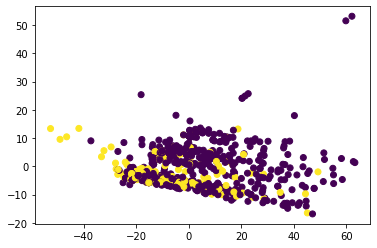

In [6]:
#plot 
scatter(X[:,1], X[:,2], c=target)

# Functions

In [11]:
def rotate_dist(D, theta_rotation=0, dimension=[0,1]):
    #dimensions to rotate
    X = D.copy()
    Z = X[:, dimension]
    
    #rotation
    c, s = np.cos(theta_rotation), np.sin(theta_rotation)
    R = np.array([[c, -s], [s, c]])
    Z = (R @ Z.T).T
    
    #recombine
    X[:, dimension] = Z
    
    return X

In [44]:
def split_task(X, y):
    D = np.hstack((X, y))
    np.random.shuffle(D)
    
    n,_ = np.shape(D)
    m = int(n/2)
    D1 = D[:m, :]
    D2 = D[m:, :]
    
    X1 = D1[:, :-1]
    X2 = D2[:, :-1]
    
    y1 = D1[:, -1]
    y2 = D2[:, -1]
    
    return X1, y1, X2, y2

In [45]:
X1, y1, X2, y2 = split_task(X, target[:, np.newaxis])

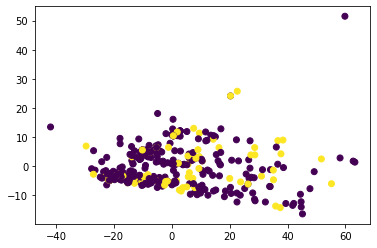

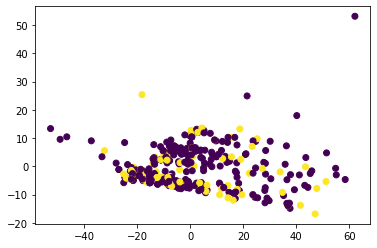

In [46]:
#plot
figure(1)
scatter(X1[:,1], X1[:,2], c=y1)

#plot
figure(2)
scatter(X2[:,1], X2[:,2], c=y2)

In [47]:
np.shape(X)

(748, 3)